In [1]:
import numpy as np
import tskit, msprime
import COPYtest_extend_edges as ee
from IPython.display import SVG
import COPYevaluation as ev
from tqdm import tqdm
import plotly.graph_objects as go

In [2]:
def ext_edges(ts, max_iter):
    return ts.extend_edges(max_iter)

def ext_paths(ts, max_iter):
    return ee.extend_paths(ts, max_iter)

def total_extend(ts, max_iter, extend_first = True):
    last_num_edges = ts.num_edges
    if extend_first is True:
        extension = [ext_edges, ext_paths]
    if extend_first is False:
        extension = [ext_paths, ext_edges]
    # print(last_num_edges)
    for _ in range(max_iter):
        for e in extension:
            # print(e)
            ts = e(ts, max_iter)
            # print(ts.num_edges)
        if ts.num_edges == last_num_edges:
            break
        if ts.num_edges != last_num_edges:
            last_num_edges = ts.num_edges
            # print('swap')

    return ts

`sample_size = 100, population_size = 1000, sequence_length = 1e6, recombination_rate = 1e-8, random_seed = 33` runs an `assert_equals` error:

`AssertionError: EdgeTable row 1097 differs:
self.left=765147.0 other.left=746420.0
self.right=787594.0 other.right=749025.0`

`sample_size = 100, population_size = 1000, sequence_length = 5e5, coalescing_segments_only = False, random_seed = 32, recombination_rate = 1e-8` runs an `asser_equals` error.

`AssertionError: EdgeTable row 739 differs:
self.left=419786.0 other.left=404566.0
self.right=429644.0 other.right=405342.0`

In [9]:
for s in tqdm(range(32, 100)):
    ts = msprime.sim_ancestry(100, population_size = 1000, sequence_length = 1e6, coalescing_segments_only = False, random_seed = s+1,
                                 recombination_rate = 1e-8)
    sts = ts.simplify()
    # teee = total_extend(sts, 10000, True)
    teep = total_extend(sts, 10000, False)
    sts.tables.assert_equals(teep.simplify().tables, ignore_provenance = True)

  0%|                                                                                            | 0/68 [01:09<?, ?it/s]


AssertionError: EdgeTable row 1097 differs:
self.left=765147.0 other.left=746420.0
self.right=787594.0 other.right=749025.0

#### Check Case
`random_seed = 19` and `total_extend(sts, 10000, extend_first = True`.
This function doesn't work however, `total_extend(sts, 10000, extend_first = False)` does compute properly.

In [ ]:
STS_edges = np.zeros(100)
EE_edges = np.zeros(100)
EP_edges = np.zeros(100)
TEEE_edges = np.zeros(100)
TEEP_edges = np.zeros(100)

In [12]:
length = 1e6
samples = 50
seeds = np.arange(20,101)
same_ts = np.full((100,), False, dtype = 'bool')
for s in tqdm(seeds):
    ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, coalescing_segments_only = False, random_seed = s,
                             recombination_rate = 1e-8)
    sts = ts.simplify()
    STS_edges[s-1] = sts.num_edges
    tsee = ext_edges(sts, 10000)
    tsep = ext_paths(sts, 10000)
    teee = total_extend(sts, 10000, True)
    teep = total_extend(sts, 10000, False)
    EE_edges[s-1] = tsee.num_edges
    EP_edges[s-1] = tsep.num_edges
    TEEE_edges[s-1] = teee.num_edges
    TEEP_edges[s-1] = teep.num_edges
    same_ts[s-1] = teee == teep

100%|███████████████████████████████████████████████████████████████████████████| 81/81 [1:55:32<00:00, 85.58s/it]


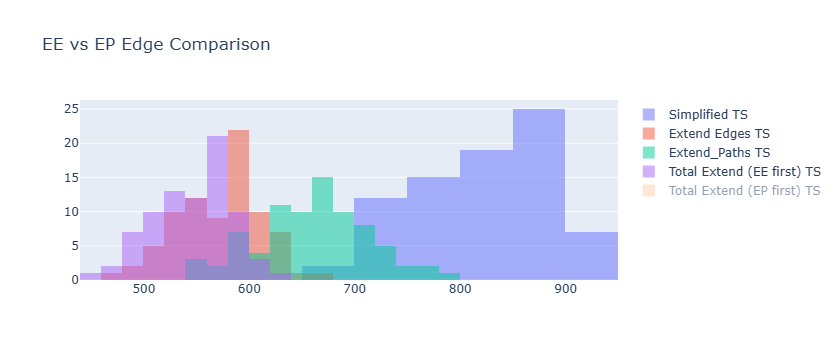

In [27]:
fig = go.Figure()
fig.add_trace(go.Histogram(x = STS_edges[20:], name = 'Simplified TS'))
fig.add_trace(go.Histogram(x = EE_edges[20:], name = 'Extend Edges TS'))
fig.add_trace(go.Histogram(x = EP_edges[20:], name = 'Extend_Paths TS'))
fig.add_trace(go.Histogram(x = TEEE_edges[20:], name = 'Total Extend (EE first) TS'))
fig.add_trace(go.Histogram(x = TEEP_edges[20:], name = 'Total Extend (EP first) TS'))
fig.update_layout(title = 'EE vs EP Edge Comparison', barmode = 'overlay')
fig.update_traces(opacity = 0.5)
fig.show()

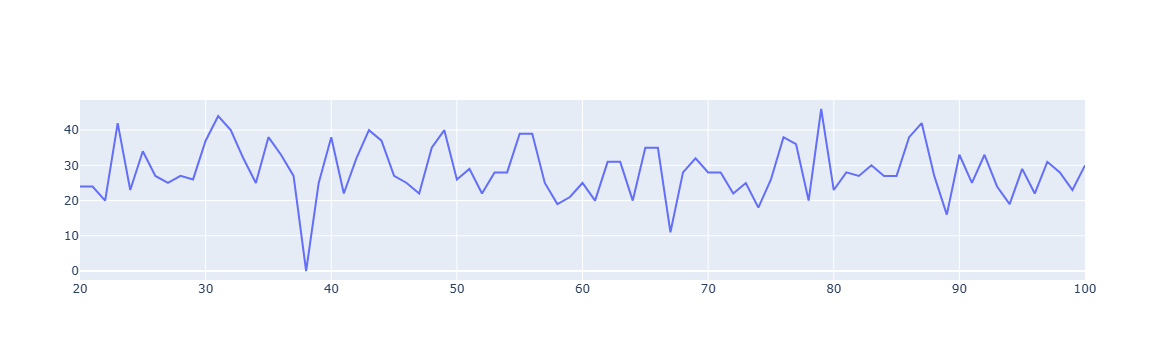

In [20]:
f = go.Figure()
f.add_trace(go.Scatter(x=seeds, y = EE_edges-TEEP_edges))
f.show()

In [19]:
np.count_nonzero(same_ts[20:]), same_ts[20:]
count = 0
for x in same_ts[20:]:
    if x:
        count+=1
count

50

## Graph some edge spans

In [18]:
s = np.random.randint(1,100)
print(s)
ts = msprime.sim_ancestry(50, population_size = 1000, sequence_length = 1e6, coalescing_segments_only = False,
                          random_seed = s, recombination_rate = 1e-8)
sts = ts.simplify()
eets = sts.extend_edges(1000)
epts = ee.extend_paths(sts, 11000)
tts = total_extend(sts, 10000, extend_first = False)
ttse = total_extend(sts, 10000, extend_first = True)
x = np.arange(1,ts.num_nodes+1)

1


In [19]:
ts_spans = ev.node_spans(ts)
tts_spans = ev.node_spans(tts)
sts_spans = ev.node_spans(sts)
eets_spans = ev.node_spans(eets)
epts_spans = ev.node_spans(epts)
ttse_spans = ev.node_spans(ttse)

In [20]:
sort_eets_spans = np.sort(eets_spans)
sort_epts_spans = np.sort(epts_spans)
sort_sts_spans = np.sort(sts_spans)
sort_ts_spans = np.sort(ts_spans)
sort_tts_spans = np.sort(tts_spans)
sort_ttse_spans = np.sort(ttse_spans)

In [23]:
tts == ttse

True

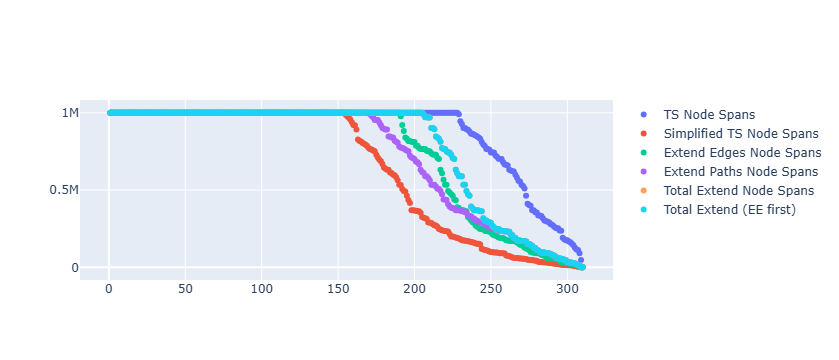

In [21]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x = x, y = sort_ts_spans[::-1], name = 'TS Node Spans', mode = 'markers'))
fig2.add_trace(go.Scatter(x = x, y = sort_sts_spans[::-1], name = 'Simplified TS Node Spans', mode = 'markers'))
fig2.add_trace(go.Scatter(x = x, y = sort_eets_spans[::-1], name = 'Extend Edges Node Spans', mode = 'markers'))
fig2.add_trace(go.Scatter(x = x, y = sort_epts_spans[::-1], name = 'Extend Paths Node Spans', mode = 'markers'))
fig2.add_trace(go.Scatter(x = x, y = sort_tts_spans[::-1], name = 'Total Extend Node Spans', mode = 'markers'))
fig2.add_trace(go.Scatter(x = x, y = sort_ttse_spans[::-1], name = 'Total Extend (EE first)', mode = 'markers'))
# fig2.update_layout(x_axes = dict('title' = 'Node'), y_axes = dict('title' = 'Node Span'))
fig2.show()

### Graph Time vs Node Span Curves as well.

In [18]:
ts_nt = ts.tables.nodes.time
sts_nt = sts.tables.nodes.time
eets_nt = eets.tables.nodes.time
epts_nt = epts.tables.nodes.time
tts_nt = tts.tables.nodes.time

In [54]:
ts_data =[[ts_spans[i], ts_nt[i]] for i in range(ts.num_nodes)]
sts_data = [[sts_spans[i], sts_nt[i]] for i in range(ts.num_nodes)]
eets_data = [[eets_spans[i], eets_nt[i]] for i in range(ts.num_nodes)]
epts_data = [[epts_spans[i], epts_nt[i]] for i in range(ts.num_nodes)]
tts_data = [[tts_spans[i], tts_nt[i]] for i in range(ts.num_nodes)]
for data in [ts_data, sts_data, eets_data, epts_data, tts_data]:
    data.sort(key = lambda x: x[1])
ts_data = np.asarray(ts_data)
sts_data = np.asarray(sts_data)
eets_data = np.asarray(eets_data)
epts_data = np.asarray(epts_data)
tts_data = np.asarray(tts_data)

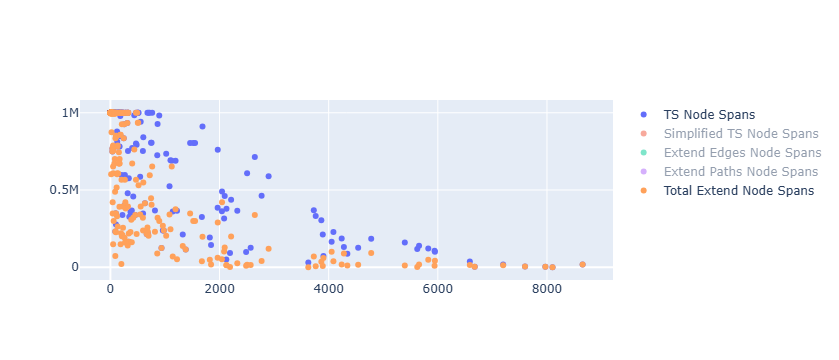

In [30]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x = ts_nt, y = ts_spans, name = 'TS Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = sts_nt, y = sts_spans, name = 'Simplified TS Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = eets_nt, y = eets_spans, name = 'Extend Edges Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = epts_nt, y = epts_spans, name = 'Extend Paths Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = tts_nt, y = tts_spans, name = 'Total Extend Node Spans', mode = 'markers'))
fig3.show()

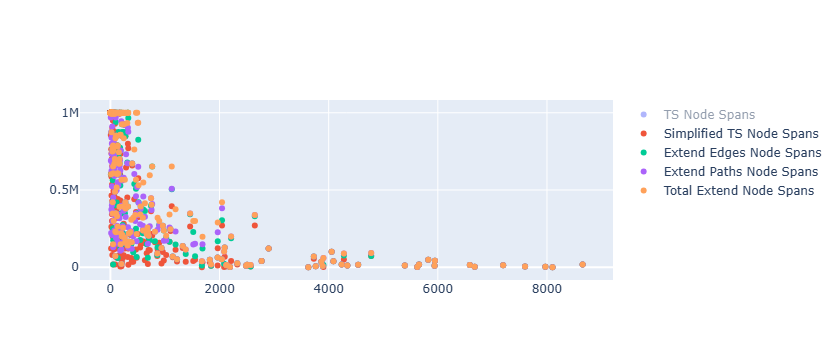

In [57]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x = ts_data[:,1], y = ts_data[:,0], name = 'TS Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = sts_data[:,1], y = sts_data[:,0], name = 'Simplified TS Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = eets_data[:,1], y = eets_data[:,0], name = 'Extend Edges Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = epts_data[:,1], y = epts_data[:,0], name = 'Extend Paths Node Spans', mode = 'markers'))
fig3.add_trace(go.Scatter(x = tts_data[:,1], y = tts_data[:,0], name = 'Total Extend Node Spans', mode = 'markers'))
fig3.show()

### Sequence Issue
Check `total_extend(extend_first = True)` for `random_seed = 19`.

#### Thoughts on the issue (5/20).
Currently, on iteration 1 (back pass on the second pass through) for extend paths there exists an edge `EdgeTableRow(left=550452.0, right=858392.0, parent=309, child=295, metadata=b'')`.
A second edge `EdgeTableRow(left=858392.0, right=919070.0, parent=301, child=295, metadata=b'')` on the pass gets extended to become edge:
`EdgeTableRow(left=852261.0, right=919070.0, parent=301, child=295, metadata=b'')`. We then assign `nodes_edge[295]` to be this edge.

Later... on the tree below we have the following output.

`812988.0 806857.0`

`path [273, 295, 309, 312]`

`old edge id 469` with `old edge EdgeTableRow(left=858392.0, right=919070.0, parent=301, child=295, metadata=b'')`

`old_parent 301` and `new_parent 309`

`295 309 NEW EDGE --> EdgeTableRow(left=806857.0, right=812988.0, parent=309, child=295, metadata=b'')`

I think has happened as once we have delared `nodes_edge[295]` as the one above, it did not reupdate in the next tree.

`----------- 828361.0 852261.0 ----------`.

as the original tree sequence has already recorded it as in this tree.
We may have to construct some machinery to record when this happens to readjust this `tree_pos` object.
This may also increase efficiency on the `extend_paths` function, as currently I am not sure if it is extending edges 
more than one tree at a time per pass of the algorithm.
ie. I believe that an edge can be extended $T_1 \to T_2$ during a single forward pass, but no further as the `tree_pos` is not updated 
for this extension.

In [3]:
ts = msprime.sim_ancestry(50, population_size = 1000, sequence_length = 1e6, coalescing_segments_only = False, random_seed = 19,
                             recombination_rate = 1e-8)
sts = ts.simplify()
teee = total_extend(sts, 10000, True)
# teep = total_extend(sts, 10000, False)

<function ext_edges at 0x7f2c5a27f310>
<function ext_paths at 0x7f2c5a27f3a0>
0
TREE SCAN IN RANGE 551641.0 557342.0
295 edge 468
295 parent 309
-----------------
TREE SCAN OUT RANGE 868181.0 873886.0
295 edge -1
295 parent 309
--------
TREE SCAN IN RANGE 868181.0 873886.0
295 edge 448
295 parent 301
-----------------
TREE SCAN OUT RANGE 919070.0 926446.0
295 edge -1
295 parent 301
--------
TREE SCAN IN RANGE 919070.0 926446.0
295 edge 615
295 parent 347
-----------------
TREE SCAN OUT RANGE 929060.0 930315.0
295 edge -1
295 parent 347
--------
TREE SCAN IN RANGE 929060.0 930315.0
295 edge 449
295 parent 301
-----------------
0
TREE SCAN IN RANGE 1000000.0 998360.0
295 edge 449
295 parent 301
-----------------
TREE SCAN OUT RANGE 929060.0 927350.0
295 edge -1
295 parent 301
--------
TREE SCAN IN RANGE 929060.0 927350.0
295 edge 615
295 parent 347
-----------------
TREE SCAN OUT RANGE 919070.0 902267.0
295 edge -1
295 parent 347
--------
TREE SCAN IN RANGE 919070.0 902267.0
295 edge 448

In [4]:
teee == sts

False

In [5]:
teee.num_edges, sts.num_edges

(592, 928)

In [7]:
sts.tables.assert_equals(teee.simplify().tables, ignore_provenance = True)